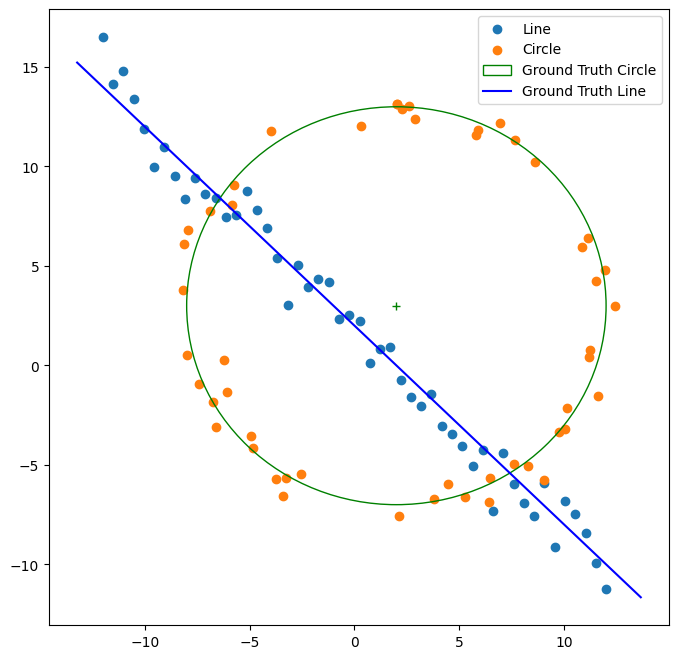

In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Generate noise points

# Parameters
N = 100  # number of points
half_n = N // 2  # half the number 
r = 10  # Radius
x0_gt, y0_gt = 2, 3  # Ground truth center 

# genrate noisy circle points
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)  # Angle
n = s * np.random.randn(half_n)  # Noise
x = x0_gt + (r + n) * np.cos(t)  
y = y0_gt + (r + n) * np.sin(t)  
X_circ = np.column_stack((x, y))  

# creating noisy line points
s = 1.0
m, b = -1, 2  
x = np.linspace(-12, 12, half_n)  
y = m * x + b + s * np.random.randn(half_n)  
X_line = np.column_stack((x, y))  

# conbine all the points
X = np.vstack((X_circ, X_line))  

# Plot the noisy point set
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

# Ground truth line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='b', label='Ground Truth Line')
plt.legend()
